In [1]:
#Importamos las librerias

In [2]:
from sklearn.datasets import load_wine #Contiene el dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#Guardo el dataset en el objeto wine
wine = load_wine(as_frame=True)

#Convierto el frame de sklearn en un dataframe pandas
dataset = pd.DataFrame(data= np.c_[wine['data'], wine['target']],
                     columns= wine['feature_names'] + ['target'])

dataset

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2.0


In [4]:
# Un poco de analisis exploratorio
columnas = dataset.columns
print(columnas)

dataset.describe()


Index(['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
       'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
       'proanthocyanins', 'color_intensity', 'hue',
       'od280/od315_of_diluted_wines', 'proline', 'target'],
      dtype='object')


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


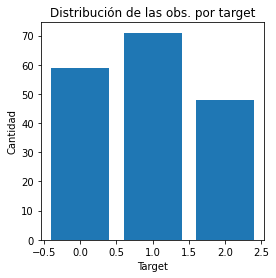

In [5]:
bar= dataset.groupby(['target'])['target'].count().reset_index(name="n")
bar= pd.DataFrame(bar)

fig = plt.figure(figsize =(4,4))
plt.bar(bar['target'],bar['n'])
plt.xlabel("Target")
plt.ylabel("Cantidad")
plt.title("Distribución de las obs. por target")
plt.show()


#### Observaciones

 - el archivo de datos esta compuesto por variables numéricas lo cuál no implica aplicar una transformación one hot encode a ninguna de las variables.
 - Los predictores son 14 y una variable target.
 - La variable target toma 3 valores, 0, 1 y 2 y la mayoría de las observaciones corresponden a la categoría 1. 

## Preprocesamiento

In [6]:
#Realizamos escalado y normalizacion de todos los predictores

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

#Selecciono solo los predictores

x = dataset.drop('target', axis=1)

np.random.seed(123)

#Escalado

escala=MinMaxScaler()

escala.fit(x)

x_escalada = escala.transform(x)

#print(x_escalada)

#Normalizado

normalize = Normalizer()

normalize.fit(x)

x_normalizada = normalize.transform(x)

#Estandarizado

estandarizado = StandardScaler()

estandarizado.fit(x)

x_estandarizada = estandarizado.transform(x)


#Corroboramos el estandarizado

print("------------------------------------")
print("Comprobaciones de la estandarizacion")
print("------------------------------------")
print(x_estandarizada.mean(axis=0)) #No es 0, pero es muy cercano a 0
print(x_estandarizada.std(axis=0)) #El desvio es 1 para todos los predictores.



------------------------------------
Comprobaciones de la estandarizacion
------------------------------------
[-8.38280756e-16 -1.19754394e-16 -8.37033314e-16 -3.99181312e-17
 -3.99181312e-17  0.00000000e+00 -3.99181312e-16  3.59263181e-16
 -1.19754394e-16  2.49488320e-17  1.99590656e-16  3.19345050e-16
 -1.59672525e-16]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


#### Observaciones

 - Con la función StandarScale() hacemos que los predictores se estandaricen, lo que implica que todos pasan a tener media 0 y desviación estándar 1. En el ejercicio la media no es 0, pero es muy cercana y por eso se acepta que esta correcto el estandarizado.
 - Con esta estrategia evitamos que por la unidad de medida del predictor, alguno tenga más peso que el resto.

### Division del dataset en train y test

In [7]:
# Comenzamos con los datos sin procesar
from sklearn.model_selection import train_test_split


X_train,X_test,y_train, y_test = train_test_split(
dataset.drop('target', axis=1),dataset['target'], random_state=123, test_size= 0.2)


In [8]:
#Continuamos con los datos preprocesados

from sklearn.model_selection import train_test_split

#Guardamos en el objeto y la variable target

y = dataset['target'].astype(int)

X_train_s,X_test_s,y_train_s, y_test_s = train_test_split(
x_estandarizada,y, random_state=123, test_size= 0.2)



## Entrenamos un modelo Knn

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

#Instanciamos el modelo

knn = KNeighborsClassifier(3)

#Entrenamos el modelo

original = knn.fit(X_train,y_train)
preprocesado = knn.fit(X_train_s,y_train_s)

#Hacemos predicciones

y_predicha_original = original.predict(X_test)

y_predicha_preprocesado = preprocesado.predict(X_test_s)

#Obtenemos algunas métricas de error

print("Accurracy")
print("--------------------------------------------")
print("El accuracy obtenido sin escalar es:", round(knn.score(X_test, y_test),3))
print("El accuracy obtenido preprocesado es:", round(knn.score(X_test_s, y_test_s),3))
print("--------------------------------------------")

#Obtenemos el roc_auc

print("ROC_AUC")
print("--------------------------------------------")
print("El roc_auc obtenido sin escalar es:", round(roc_auc_score(y_test,original.predict_proba(X_test),multi_class= 'ovo'),3))
print("El roc_auc obtenido preprocesado es:", round(roc_auc_score(y_test,preprocesado.predict_proba(X_test_s),multi_class= 'ovo'),3))
print("--------------------------------------------")


Accurracy
--------------------------------------------
El accuracy obtenido sin escalar es: 0.222
El accuracy obtenido preprocesado es: 0.972
--------------------------------------------
ROC_AUC
--------------------------------------------
El roc_auc obtenido sin escalar es: 0.5
El roc_auc obtenido preprocesado es: 0.999
--------------------------------------------


#### Observaciones

 - Las dos métricas elegidas para evaluar el __modelo KNN__, muestran una __mejor performance__ cuando el modelo utiliza los __datos estandarizados__, llegando a un accuracy de __0.97__ y el roc_auc de __0.99__, vs los 0.22 y 0.5 obtenido con los datos sin estandarizar.

In [10]:
# Obtenemos la matriz de confusión para ambos dataset (original y preprocesado)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Matriz de confusion datos originales
cm = confusion_matrix(y_test,y_predicha_original)

#Matriz de confusión datos preprocesados

cm_s = confusion_matrix(y_test,y_predicha_preprocesado)


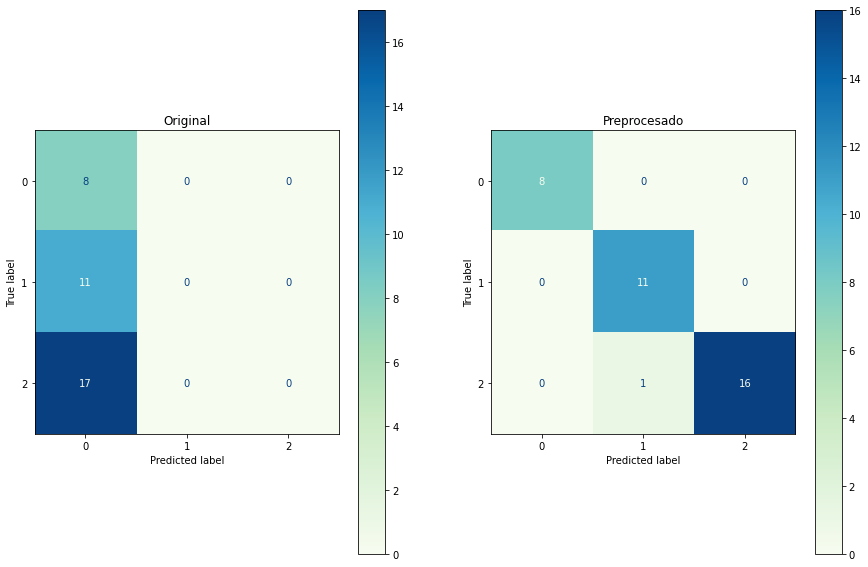

In [11]:
fig, ax = plt.subplots(1,2, figsize=(15,10))
ax[0].set_title("Original")
ax[1].set_title("Preprocesado")


disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=knn.classes_)

disp.plot(cmap=plt.cm.GnBu,ax=ax[0])

disp = ConfusionMatrixDisplay(confusion_matrix=cm_s,
                              display_labels=knn.classes_)

disp.plot(cmap=plt.cm.GnBu,ax=ax[1])


#### Observaciones

 - La __matriz de confusión__ muestra de forma más explicita lo que describiamos en el apartado anterior. Cuando el __modelo KNN__ utiliza los datos sin estandarizar (imágen de la izquierda), clasifica las 36 observaciones del dataset de test en 0, cuando __solo 8__ debieron ser clasificadas con este valor. 
 - En cambio, cuando __modelo KNN__ utiliza los datos estandarizados (imágen de la derecha), __clasifica correctamente__ __35 de las 36__ observaciones del __dataset de test__.

## Entrenamos un modelo de DecisionTree

In [12]:
#importamos el modelo

from sklearn.tree import DecisionTreeClassifier

#generamos una semilla aleatoria

np.random.seed(123)

#Instanciamos el modelo
tree = DecisionTreeClassifier(max_depth=3)

#Entrenamos el modelo

arbol_original = tree.fit(X_train,y_train)
arbol_preprocesado = tree.fit(X_train_s,y_train_s)

#Hacemos predicciones

y_arbol_original = arbol_original.predict(X_test)

y_arbol_preprocesado = arbol_preprocesado.predict(X_test_s)

#Obtenemos algunas métricas de error

print("Accurracy")
print("--------------------------------------------")
print("El accuracy obtenido sin escalar es:", round(tree.score(X_test, y_test),3))
print("El accuracy obtenido preprocesado es:", round(tree.score(X_test_s, y_test_s),3))
print("--------------------------------------------")

#Obtenemos el roc_auc

print("ROC_AUC")
print("--------------------------------------------")
print("El roc_auc obtenido sin escalar es:", round(roc_auc_score(y_test,arbol_original.predict_proba(X_test),multi_class= 'ovo'),3))
print("El roc_auc obtenido preprocesado es:", round(roc_auc_score(y_test_s,arbol_preprocesado.predict_proba(X_test_s),multi_class= 'ovo'),3))
print("--------------------------------------------")


Accurracy
--------------------------------------------
El accuracy obtenido sin escalar es: 0.222
El accuracy obtenido preprocesado es: 0.972
--------------------------------------------
ROC_AUC
--------------------------------------------
El roc_auc obtenido sin escalar es: 0.5
El roc_auc obtenido preprocesado es: 0.971
--------------------------------------------


#### Observaciones

 - Al igual que lo observado en el entrenamiento del modelo KNN, aqui podemos observar que tanto el accuracy como el roc_auc muestran mejor performance con los datos preprocesados.

### Optimizamos el hiperparámetro max_depth

In [13]:
### Optimizamos el parámetro max_depth, utlizando GridSeacrhCV

from sklearn.model_selection import GridSearchCV #grid search

#generamos una semilla aleatoria

np.random.seed(123)

# Hiperoptimizacion del max_depth

param_grid = { 
    'max_depth' : [3,4,5,6,7],
    'criterion' :['gini', 'entropy']
}

#Modelo

arbol = DecisionTreeClassifier()

model_grid = GridSearchCV(estimator=arbol, param_grid=param_grid, cv= 5, refit= True)

#Entrenamos el modelo con datos preprocesados

model_grid_fit = model_grid.fit(X_train_s, y_train_s)



In [14]:
#Buscamos el mejor estimador

print("Mejor estimador modelo con datos preprocesados")
print("--------------------------------------------")
print(model_grid_fit.best_estimator_)
print("--------------------------------------------")

Mejor estimador modelo con datos preprocesados
--------------------------------------------
DecisionTreeClassifier(criterion='entropy', max_depth=6)
--------------------------------------------


In [15]:
#Vemos los errores

resultados = pd.DataFrame(model_grid_fit.cv_results_)
resultados.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False)



,param_criterion,param_max_depth,mean_test_score,std_test_score
8,entropy,6,0.901478,0.034236
2,gini,5,0.895567,0.077987
1,gini,4,0.894581,0.049852
5,entropy,3,0.894581,0.030897
0,gini,3,0.894335,0.044828
6,entropy,4,0.894335,0.049153
9,entropy,7,0.894335,0.031450
4,gini,7,0.881034,0.063064
7,entropy,5,0.881034,0.063064
3,gini,6,0.873645,0.034391


In [16]:
# Ahora vamos a entrenar nuestro mejor modelo con los parámetros optimizados

#importamos el modelo

from sklearn.tree import DecisionTreeClassifier

#generamos una semilla aleatoria

np.random.seed(123)

#Instanciamos el modelo
tree_opt = DecisionTreeClassifier(max_depth=6,criterion='entropy')

#Entrenamos el modelo

arbol_optimizado = tree_opt.fit(X_train_s,y_train_s)

#Hacemos predicciones

y_arbol_opt = arbol_optimizado.predict(X_test_s)

#Analizamos las metricas de error

print("Accurracy")
print("--------------------------------------------")
print("El accuracy obtenido con el modelo optimizado es:", round(tree_opt.score(X_test_s, y_test_s),3))
print("--------------------------------------------")

print("ROC_AUC")
print("--------------------------------------------")
print("El roc_auc obtenido con el modelo optimizado es:", round(roc_auc_score(y_test_s,arbol_optimizado.predict_proba(X_test_s),multi_class= 'ovo'),3))
print("--------------------------------------------")



Accurracy
--------------------------------------------
El accuracy obtenido con el modelo optimizado es: 0.944
--------------------------------------------
ROC_AUC
--------------------------------------------
El roc_auc obtenido con el modelo optimizado es: 0.971
--------------------------------------------


#### Observaciones

 - Se __optimizaron 2 hiperparámetros__ del modelo de DecisionTree, el __max_depth__ y el __criterio de división__ mediante la estrategia __GridSearchCV__.
 - La tabla _resultados_ muestra los modelos entrenados con distintas combicaciones de los hiperparámetros. Asmismo muestra el promedio del accuracy ordenados de mayor a menor.
 - De allí podemos saber que el modelo más optimo es el que setea los parámtros __max_depth__ en __6__ y __criterion__ __entropy__ .
 - En este caso particuar la __optimización de los parámetros__ no implicó una mejora en las métricas de error, incluso se obtuvo un menor accuracy.

### Vemos la importancia de los predictores

In [17]:
#Vemos la importancia de los predictores

importancia_predictores = pd.DataFrame(
                            {'predictor': x.columns,
                             'importancia':tree.feature_importances_}
                            )
importancia_predictores.sort_values('importancia', ascending=False)

,predictor,importancia
12,proline,0.465469
11,od280/od315_of_diluted_wines,0.303665
6,flavanoids,0.118134
10,hue,0.081056
9,color_intensity,0.031675
0,alcohol,0.000000
1,malic_acid,0.000000
2,ash,0.000000
3,alcalinity_of_ash,0.000000
4,magnesium,0.000000


#### Observaciones

 - Aquí podemos observar que los __feature__ _proline_ y _od280/od315_of_diluted_wines_ son los que mayor importancia tuvieron en el modelo.

## Aplicamos un modelo de reducción de dimensionalidad

### Utilizamos el Análisis de la componente principal

(178, 13)
(178, 2)


,PC-1,PC-2
flavanoids,0.422934,0.003360
total_phenols,0.394661,-0.065040
od280/od315_of_diluted_wines,0.376167,0.164496
proanthocyanins,0.313429,-0.039302
hue,0.296715,0.279235
proline,0.286752,-0.364903
alcohol,0.144329,-0.483652
magnesium,0.141992,-0.299634
ash,-0.002051,-0.316069
color_intensity,-0.088617,-0.529996


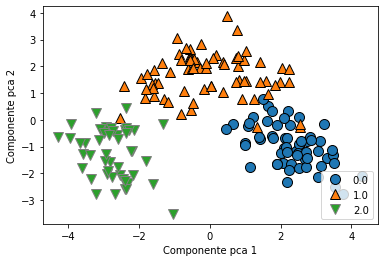

In [18]:
from sklearn.decomposition import PCA
import mglearn

#Instanciamos el modelo PC
pca=PCA(n_components=2)

#Entrenamoe el modelo
pca.fit(x_estandarizada)

#Transformamos los datos estandarizados
transformados = pca.transform(x_estandarizada)
print(x.shape)
print(transformados.shape)

#hacemos un gráfico


mglearn.discrete_scatter(transformados[:,0], transformados[:,1], dataset['target'])
plt.legend(dataset['target'].unique(), loc='lower right')
plt.xlabel('Componente pca 1')
plt.ylabel('Componente pca 2')

#Creamos un dataframe con los predictores que quedan incluidos en ambos componentes principales

predictores = pd.DataFrame(pca.components_.T, columns= ['PC-1','PC-2'], index= x.columns)

predictores.sort_values('PC-1',ascending = False)

In [19]:
print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print('----------------------------------------------------')
print(pca.explained_variance_ratio_)
print('--------------------------------------------------------------')
print('Porcentaje de varianza acumulada explicada por cada componente')
print('--------------------------------------------------------------')
print(pca.explained_variance_ratio_.cumsum())

----------------------------------------------------
Porcentaje de varianza explicada por cada componente
----------------------------------------------------
[0.36198848 0.1920749 ]
--------------------------------------------------------------
Porcentaje de varianza acumulada explicada por cada componente
--------------------------------------------------------------
[0.36198848 0.55406338]


#### Observaciones

 - En el cuadro anterior podemos observar cuáles __feature__ dentro de los componentes explican la mayor cantidad de varianza.
 - En nuestro análisis podemos ver que las variables _flavonoid_, _total_phenols_ y _od280/od315_of_diluted_wines_ tienen el mayor peso en la PC-1. Mientras que en PC-2 tienen más peso _color_intensity_, _alcohol_ y _proline_. 

## Aplicamos el modelo KMeans

-------------------------
---Tiempo de ejecución---
------- 0.09 --------
-------------------------
-----------------------------
------Indice Rand------------
El score obtenido es:  0.895
-----------------------------


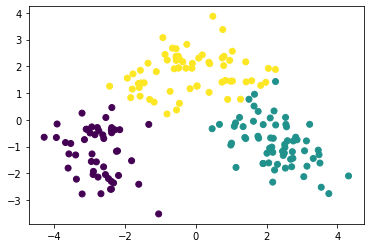

In [20]:
#Importamos la libreria
import time
from sklearn.cluster import KMeans
from sklearn import metrics

#plantamos una semilla aleatoria

np.random.seed(123)

#Instanciamos el modelo

model_k_means = KMeans(n_clusters=3, max_iter=2000) 

#Instanciamos el momento 0
t0 = time.time()

#Entrenamos el modelo
model_k_means.fit(transformados)

#Capturamos el tiempo luego de entrenar el modelo menos el momento 0
t_batch = time.time() - t0


print("-------------------------")
print("---Tiempo de ejecución---")
print("-------",round(t_batch,2),"--------")
print("-------------------------")

#Generamos las predicciones

pred_k_means = model_k_means.predict(transformados)

#Obtenemos las métricas de error

score=metrics.adjusted_rand_score(dataset['target'], pred_k_means)

print("-----------------------------")
print("------Indice Rand------------")
print("El score obtenido es: ",round(score,3))
print("-----------------------------")

#Graficamos las predicciones


plt.scatter(transformados[:, 0], transformados[:, 1], c=pred_k_means)

plt.show()

## Aplicamos el modelo KMeans mini-batches 

-------------------------
---Tiempo de ejecución---
--------- 0.0 ----------
-------------------------
-----------------------------
------Indice Rand------------
El score obtenido es:  0.896
-----------------------------


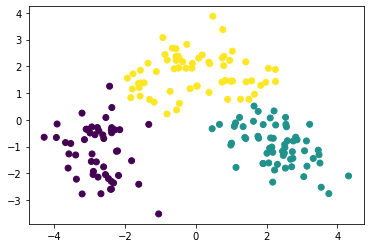

In [21]:
# importamos el modelo de la libreria cluster

from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics
import time

#plantamos una semilla aleatoria

np.random.seed(123)


#Instanciamos el momento 0
t1 = time.time()

#Instanciamos el mismo modelo pero Mini batches

k_means_mb = MiniBatchKMeans(n_clusters=3, max_iter=2000)

#Capturamos el tiempo luego de entrenar el modelo menos el momento 0
t_batch_1 = time.time() - t1

print("-------------------------")
print("---Tiempo de ejecución---")
print("---------",round(t_batch_1,2),"----------")
print("-------------------------")

#Entrenamos el modelo tulizando los datos escalados

k_means_mb.fit(transformados)

#Creamos las predicciones del modelo

pred_k_means_mb = k_means_mb.predict(transformados)

#Obtenemos las métricas de error

score_mb= metrics.adjusted_rand_score(dataset['target'], pred_k_means_mb)

print("-----------------------------")
print("------Indice Rand------------")
print("El score obtenido es: ",round(score_mb,3))
print("-----------------------------")

#Graficamos las predicciones


plt.scatter(transformados[:, 0], transformados[:, 1], c=pred_k_means_mb)

plt.show()



#### Observaciones

 - Podemos observar que el modelo K-Means Mini Batch nos permite agrupar los datos en cluster con una menor precisión que K-means (score 0.847 vs 0.895). Ahora bien, desde el punto de vista del tiempo de ejecución obtenido con la __libreria time__, podemos observar que el modelo K-means tardo 0.4 s y el modelo K-means Mini Batch tarda 0.0 s. 
 - En conclusión, el modelo __K-means Mini Batch__ es más __eficiente__ obteniendo métricas de error solo __levemente mayores__ al __modelo K-means__.

### Bonus Track

Quizás un primer paso que debería haber implementado es utilizar una matriz de correlación para observar la existencia de __colinealidad__ y en su defecto excluir los predictores que este correlacionados.
En esta etapa analizaremos los predictores mediante una __matriz de correlación__.

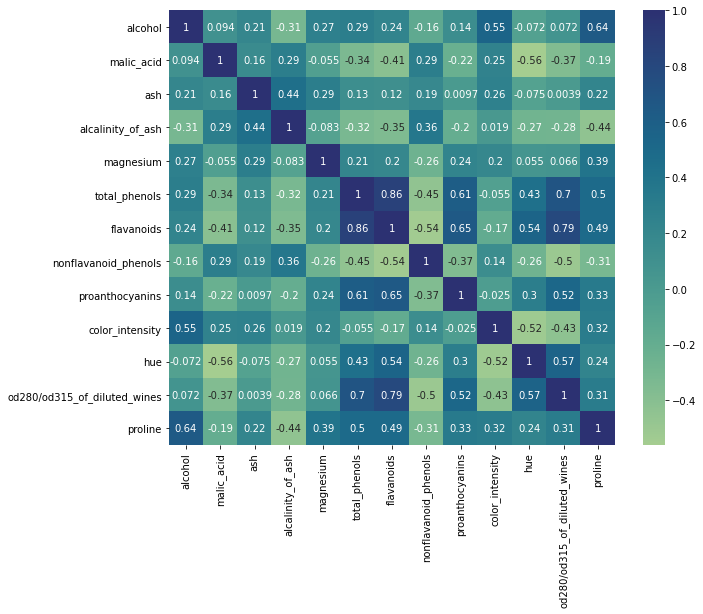

Index(['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
       'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
       'proanthocyanins', 'color_intensity', 'hue',
       'od280/od315_of_diluted_wines', 'proline'],
      dtype='object')


In [22]:
#Armamos un data frame con los predictores
data_corr = pd.DataFrame(x_estandarizada, columns = x.columns)

#Mostramos la matriz de correlacion

corr_mat = data_corr.corr()

#Graficamos la matriz de correlacion

import seaborn as sn

plt.figure(figsize=(10, 8))


sn.heatmap(corr_mat, annot=True,cmap="crest")

plt.show()

print(x.columns)

#### Observaciones

 - En la matriz se puede observar una fuerte correlación entre las siguientes variables/predictores:
     - proline y alcohol: 0.64
     - od280/od315_of_diluted_wines y total_phenols
     - proanthocyanins y total_phenols
     - flavanoids y total_phenols
     - od280/od315_of_diluted_wines y flavanoids
     
 - Teniendo en cuenta lo anterior puede excluise del modelo __total_phenols__, __flavanoids__, __od280/od315_of_diluted_wines__. 